In [1]:

%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from math import sqrt,erf
from multiprocessing import Pool
from itertools import product, repeat
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib as mpl
import numpy as np
from itertools import product
from matplotlib.cm import get_cmap
# import colorcet as cc
import subprocess
import os, shutil
from time import time
import functools
from scipy import special
import scipy
from IPython.display import display, clear_output
import fermionise as fermionise
import eigenstateRG as eigRG



#plt.style.use('ggplot')
markers = ["o", "X", "P", "p", "*"]
cols = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{braket}\usepackage{nicefrac}')
plt.rcParams.update({'font.size': 30,
                     'figure.figsize': (11,7),
                     'axes.facecolor': 'white',
                     'axes.edgecolor': 'lightgray',
                     "figure.autolayout": 'True',
                     'axes.xmargin': 0.03,
                     'axes.ymargin': 0.05,
                     'axes.grid': False,
                     'axes.linewidth': 5,
                     'lines.markersize': 15,
                     #'text.usetex': True,
                     'lines.linewidth': 8,
                     "legend.frameon": True,
                     "legend.framealpha": 0.7,
                     "legend.handletextpad": 1,
                     "legend.edgecolor": "black",
                     "legend.handlelength": 1,
                     "legend.labelspacing": 0,
                     "legend.columnspacing": 1,
                     "legend.fontsize": 35,
                    })
linestyles = ["-", "--", ":"]
bbox = dict(boxstyle="round", facecolor="lightgray")

D0 = 1
deltaD = 0.001
plt.plot([], [])
plt.show()
clear_output()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
#### RETURNS THE DENOMINATORS THAT APPEAR IN RG EQUATIONS ####

def getDenominators(omega, D, U, J, Ub):
    d0 = omega - D/2 + Ub/2 - U/2
    d1 = omega - D/2 + Ub/2 + U/2 + J/4
    d2 = omega - D/2 + Ub/2 + J/4
    return np.array([d0, d1, d2])



#### RETURNS THE MODIFIED SET OF COUPLINGS AT A GIVEN RG STEP ####

def rg_flow(omega, D0, DELTA_D, energyDOS, D, U, V, J, signs, Ub):
    denominators = getDenominators(omega, D, U, J, Ub)
    theta = 1 * (signs * denominators > 0)
    deltaU = energyDOS(D0, D) * DELTA_D * (4*V**2 * (theta[1]/denominators[1] - theta[0]/denominators[0]) - J**2 * theta[2] / denominators[2])
    deltaV = -energyDOS(D0, D) * DELTA_D * (3 * J * V / 8) * (theta[1]/denominators[1] + theta[2]/denominators[2])
    deltaJ = -energyDOS(D0, D) * DELTA_D * (J**2 + 4*J*Ub) * theta[2]/denominators[2]

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J

#### TAKES BARE PARAMETER VALUES AND RETURNS THE COMPLETE RG FLOW ####

def complete_RG(D0, DELTA_D, energyDOS, U0, V0, J0, Ub):
    omega = -U0/4
    signs = np.sign(getDenominators(omega, D0, U0, J0, Ub))
    E, U, V, J = [[g0] for g0 in (D0, U0, V0, J0)]
    for D in np.arange(D0, 0, -DELTA_D):
        U_j, V_j, J_j = rg_flow(omega, D0, DELTA_D, energyDOS, D, U[-1], V[-1], J[-1], signs, Ub)
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - DELTA_D)
        denominators = getDenominators(omega, E[-1], U[-1], J[-1], Ub)
        if True not in np.equal(np.sign(denominators), signs):
            break
        
    return np.flip(E), np.flip(U), np.flip(V), np.flip(J)



In [3]:

def eSIAM_MERG(D0, U0, V0, J0, Ub, num_entangled, num_IOMs):
    deltaD = 0.01
    
    def flatDOS(D0, D):
        return 1/D0
        
    D, U, V, J = complete_RG(D0, deltaD, flatDOS, U0, V0, J0, Ub)
    print(J[0]/J0, V[0]/V0, U[0]/U0)
    
    omega = -U0/4
    Ek = np.linspace(deltaD, D[0], num_entangled)
    alpha_arr = [(Ji / (omega - Di/2 + Ji/4 + Ub/2), Vi / (omega - Di/2 - Ui/2 + Ub/2), Vi / (omega - Di/2 + Ui/2 + Ji/4 + Ub/2), Ub / (omega - Di/2 + Ji/4 + Ub/2), 
                  Vi / (omega - Di/2 + Ji/4 + Ub/2)) for Di, Ui, Vi, Ji in zip(D[1:], U[1:], V[1:], J[1:])][:num_IOMs]
    print(alpha_arr[0])
    if Ub <-0.25 * J0 :
        V = np.zeros(len(D))
        J = np.zeros(len(D))
    
    init_couplings = [Ek, V[0], U[0], -U[0]/2, J[0], Ub]
    decomposition_arr = eigRG.getWavefunctionRG(init_couplings, alpha_arr, num_entangled, num_IOMs, 
                                                fermionise.get_eSIAMHamiltonian, eigRG.getEta_eSIAM
                                              )
    print (decomposition_arr[0])
    print (decomposition_arr[1])
    computation_results = eigRG.computations(decomposition_arr,
                                            {"VNE": [0, 1], "I2": [[0,1],[2,3]],
                                            }
                                           )
    print("N",computation_results)

    comp_results = eigRG.computations(decomposition_arr,
                                            { "VNE": [2, 3],
                                            }
                                           )
    print("T",comp_results)

    cm_result = eigRG.computations(decomposition_arr[1:],
                                            { "I2": [[0,1],[2 + 2 *num_entangled ,2 + 2 *num_entangled + 1]],
                                            })
    cm_result["I2"] = [0] + cm_result["I2"]
    print('M',cm_result["I2"])
    cmp_result = eigRG.computations(decomposition_arr[1:],
                                            { "I2": [[2,3],[2 + 2 *num_entangled ,2 + 2 *num_entangled + 1]],
                                            })
    cmp_result["I2"] = [0] + cmp_result["I2"]                                    
    print("R",cmp_result["I2"])
    
    Sdz_operator = {"n": [[0.5,[0]],[-0.5,[1]]] }
    Sdz = [fermionise.matrixElement(genState, Sdz_operator, genState) for genState in decomposition_arr]
    print(Sdz)

    Spin_internal_Correlation_operator = {"+-+-":
            [[1, [0, 1, 2 * i + 1, 2 * j]] for i, j in product(range(1, num_entangled +  1), repeat=2)]
                                         }
    Spin_internal_Correlation = [fermionise.matrixElement(genState, Spin_internal_Correlation_operator, genState) for genState in decomposition_arr]

    Spin_internal_Correlation_operator_K = {"+-+-":
            [[1, [2, 2 + 1, 4 + 1, 4]] ]
                                         }
    Spin_internal_Correlation_K = [fermionise.matrixElement(genState, Spin_internal_Correlation_operator_K, genState) for genState in decomposition_arr]

    Spin_intOut_Correlation = []
    for genState, i in zip(decomposition_arr[1:], range(0, num_IOMs)) :
        Spin_intOut_Correlation_operator = {"+-+-":
                [[0.5, [0, 1, 2 * j + 1, 2 + 2 *num_entangled + 2 * k + 4 * i]] for j,k in product(range(1, num_entangled +  1),range(0,2))]
                                             }
        Spin_intOut_Correlation_operator["+-+-"] += (
                                [[0.5, [1, 0, 2 * j, 2 + 2 *num_entangled + 2 * k + 4 * i + 1]] for j,k in product(range(1, num_entangled +  1),range(0,2))]
        )
                    
        
        Spin_intOut_Correlation_operator["n+-"] = (
            [[0.25, [0, 2 * j, 2 + 2 *num_entangled + 2 * k + 4 * i]] for j,k in product(range(1, num_entangled +  1),range(0,2))] )
        Spin_intOut_Correlation_operator["n+-"] +=   (
            [[-0.25, [1, 2 * j, 2 + 2 *num_entangled + 2 * k + 4 * i]] for j,k in product(range(1, num_entangled +  1),range(0,2))])
        Spin_intOut_Correlation_operator["n+-"] +=   (
             [[-0.25, [0, 2 * j + 1, 2 + 2 *num_entangled + 2 * k + 4 * i + 1]] for j,k in product(range(1, num_entangled +  1),range(0,2))])
        Spin_intOut_Correlation_operator["n+-"] +=   (
             [[0.25, [1, 2 * j + 1, 2 + 2 *num_entangled + 2 * k + 4 * i + 1]] for j,k in product(range(1, num_entangled +  1),range(0,2))])
        
        Spin_intOut_Correlation.append(fermionise.matrixElement(genState, Spin_intOut_Correlation_operator, genState))
    Spin_intOut_Correlation = [0] + Spin_intOut_Correlation
    print(Spin_intOut_Correlation)

    Charge_internal_Correlation_operator = {"++--":
            [[1, [0, 1, 2 * i + 1, 2 * j]] for i, j in product(range(1, num_entangled +  1), repeat=2)]
                                         }
    Charge_internal_Correlation = [fermionise.matrixElement(genState, Charge_internal_Correlation_operator, genState) for genState in decomposition_arr]

    Charge_internal_Correlation_operator_K = {"++--":
            [[1, [2 , 2 + 1, 4+ 1, 4]] ]
                                         }
    Charge_internal_Correlation_K = [fermionise.matrixElement(genState, Charge_internal_Correlation_operator_K, genState) for genState in decomposition_arr]


    return num_entangled, num_IOMs, computation_results, comp_results, cm_result["I2"], cmp_result["I2"], Sdz, Spin_internal_Correlation, Spin_internal_Correlation_K, Spin_intOut_Correlation, Charge_internal_Correlation, Charge_internal_Correlation_K

1.1222240588153658 1.867887690597021 0.3365651422320689
(-0.313715043932418, -0.28885689836845707, -1.8795697354966894, 0.028011136648911836, -0.5203931816913282)


Obtaining operators for n .:   0%|          | 0/8 [00:00<?, ?it/s]

Obtaining operators for +- .:   0%|          | 0/4 [00:00<?, ?it/s]

Obtaining operators for +- .:   0%|          | 0/4 [00:00<?, ?it/s]

Obtaining operators for +- .:   0%|          | 0/4 [00:00<?, ?it/s]

Obtaining operators for +- .:   0%|          | 0/4 [00:00<?, ?it/s]

Obtaining operators for n .:   0%|          | 0/2 [00:00<?, ?it/s]

Obtaining operators for nn .:   0%|          | 0/1 [00:00<?, ?it/s]

Obtaining operators for n+- .:   0%|          | 0/64 [00:00<?, ?it/s]

Obtaining operators for +-+- .:   0%|          | 0/16 [00:00<?, ?it/s]

Obtaining operators for +- .:   0%|          | 0/16 [00:00<?, ?it/s]

Obtaining operators for +- .:   0%|          | 0/16 [00:00<?, ?it/s]

Obtaining operators for +-+- .:   0%|          | 0/256 [00:00<?, ?it/s]

Expressing state in terms of basis.:   0%|          | 0/1024 [00:00<?, ?it/s]

[-1.09987685 -1.09860392]
G-state energy: [-1.09987685]
{'0000000001': -6.151324293496425e-21, '0000000010': 8.447888334844886e-17, '0000000011': 0.11017336030492611, '0000000100': 4.567643056797938e-18, '0000000101': 7.087402394093803e-18, '0000000110': -0.10957030048906902, '0000000111': 3.3306690738754696e-16, '0000001000': 2.7755575615628914e-16, '0000001001': 0.10957030048906904, '0000001010': 2.168404344971009e-19, '0000001011': 5.421010862427522e-20, '0000001100': 0.1089708739679932, '0000001101': -4.786265547578831e-16, '0000001110': -1.2694906296973826e-19, '0000001111': -3.308722450212111e-24, '0000010000': -6.022903603234358e-17, '0000010001': 4.0339396105830237e-19, '0000010010': -0.10897391793828791, '0000010011': 3.304107904496133e-16, '0000010100': -4.0030357733048756e-19, '0000010101': 9.860761315262648e-32, '0000010110': 1.4844160556704526e-16, '0000010111': -1.9721522630525295e-31, '0000011000': -0.1083780828339096, '0000011001': 3.276996342663764e-16, '0000011010': 1

Computing VNE:   0%|          | 0/6 [00:00<?, ?it/s]

Computing I2:   0%|          | 0/6 [00:00<?, ?it/s]

N {'VNE': [1.3324350565429073, 1.375056927069172, 1.3697836518825055, 1.3835213935284871, 1.3795583199239425, 1.3856643643817423], 'I2': [0.7746507958856621, 0.210150799061815, 0.06418347957748383, 0.022038455846892013, 0.008452098800778796, 0.004343203814005658]}


Computing VNE:   0%|          | 0/6 [00:00<?, ?it/s]

T {'VNE': [0.7614049008650479, 0.8033656435506182, 0.8096745056336176, 0.8164756785076097, 0.8193704753383508, 0.8214771212533093]}


Computing I2:   0%|          | 0/5 [00:00<?, ?it/s]

M [0, 0.7689299628080679, 0.03578724582117232, 0.007094832417599672, 0.003985363836621847, 0.0019790771094450044]


Computing I2:   0%|          | 0/5 [00:00<?, ?it/s]

R [0, 0.06047681045486519, 0.05211379877697109, 0.0495179351330699, 0.04839419952907775, 0.04763482390505125]


  0%|          | 0/989 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/825 [00:00<?, ?it/s]

  0%|          | 0/4647 [00:00<?, ?it/s]

  0%|          | 0/22491 [00:00<?, ?it/s]

  0%|          | 0/96657 [00:00<?, ?it/s]

[6.938893903907655e-18, 0.0, 3.469446951953614e-18, 2.6021116837448123e-18, -1.0842054812079546e-18, 6.234154219985525e-19]


  0%|          | 0/989 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/825 [00:00<?, ?it/s]

  0%|          | 0/4647 [00:00<?, ?it/s]

  0%|          | 0/22491 [00:00<?, ?it/s]

  0%|          | 0/96657 [00:00<?, ?it/s]

  0%|          | 0/989 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/825 [00:00<?, ?it/s]

  0%|          | 0/4647 [00:00<?, ?it/s]

  0%|          | 0/22491 [00:00<?, ?it/s]

  0%|          | 0/96657 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/825 [00:00<?, ?it/s]

  0%|          | 0/4647 [00:00<?, ?it/s]

  0%|          | 0/22491 [00:00<?, ?it/s]

  0%|          | 0/96657 [00:00<?, ?it/s]

[0, -0.3022617848354106, -0.22195042288649572, -0.1004152408238892, -0.060064641623327024, -0.04071737230502482]


  0%|          | 0/989 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/825 [00:00<?, ?it/s]

  0%|          | 0/4647 [00:00<?, ?it/s]

  0%|          | 0/22491 [00:00<?, ?it/s]

  0%|          | 0/96657 [00:00<?, ?it/s]

  0%|          | 0/989 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/825 [00:00<?, ?it/s]

  0%|          | 0/4647 [00:00<?, ?it/s]

  0%|          | 0/22491 [00:00<?, ?it/s]

  0%|          | 0/96657 [00:00<?, ?it/s]

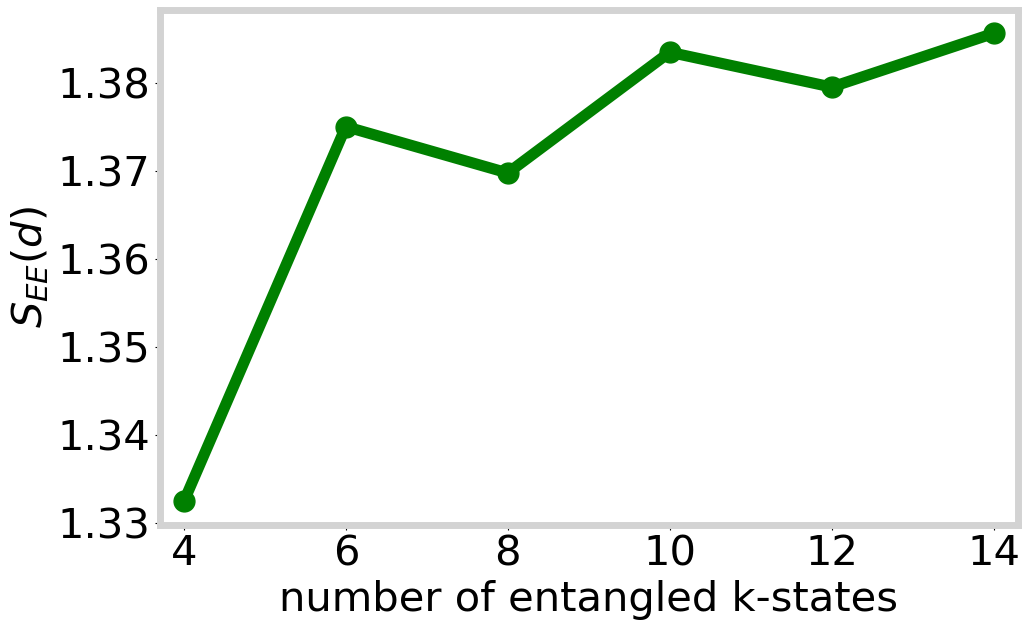

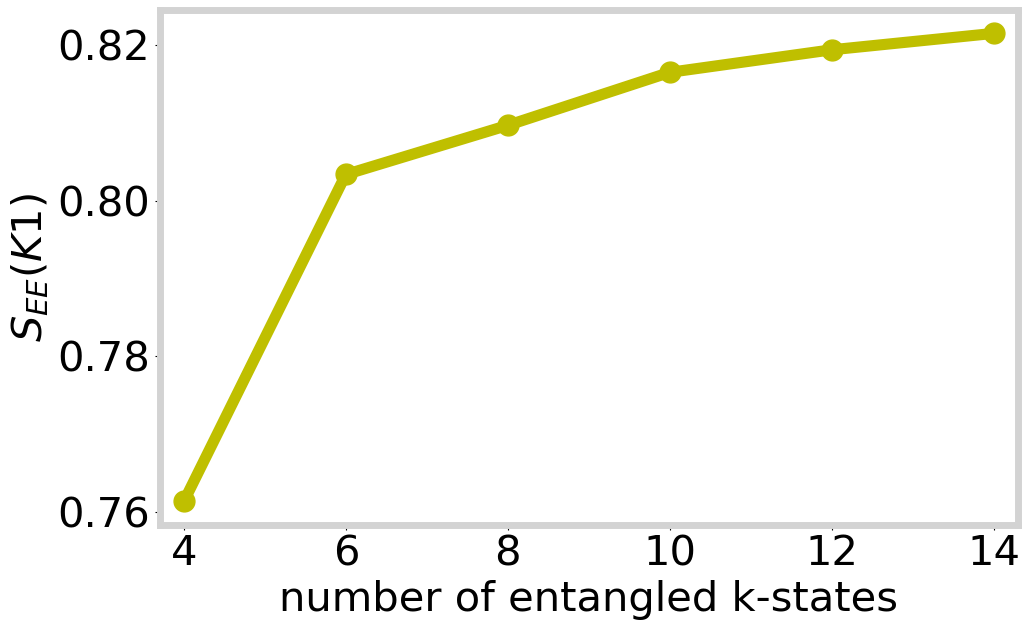

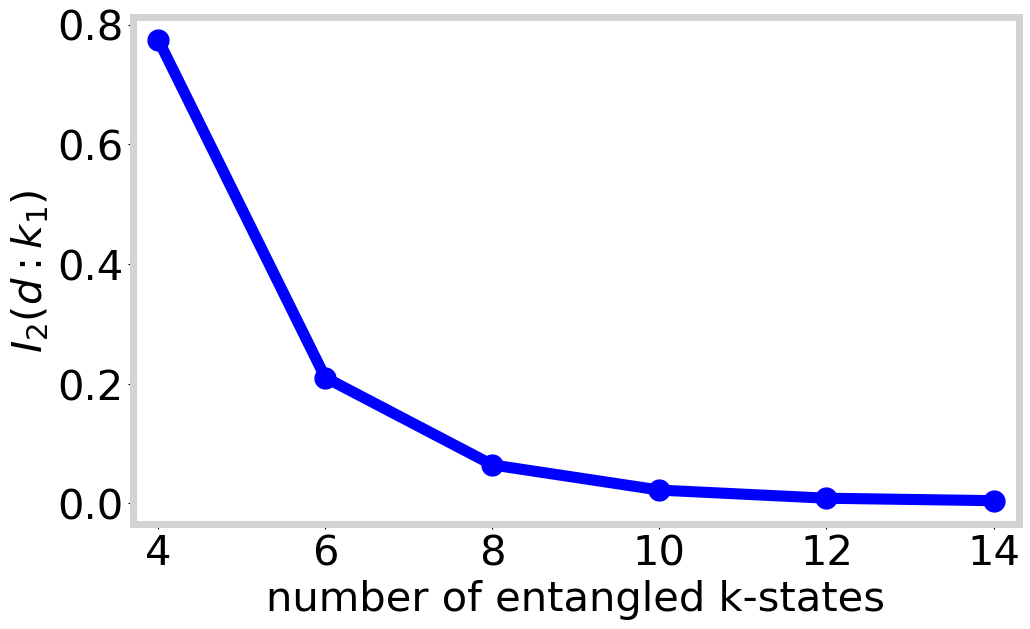

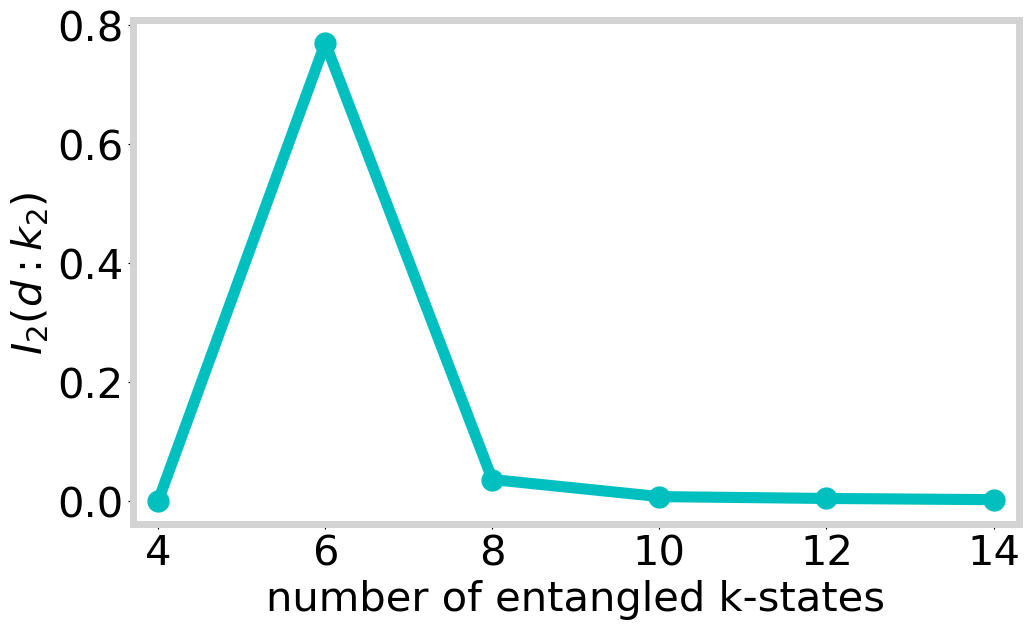

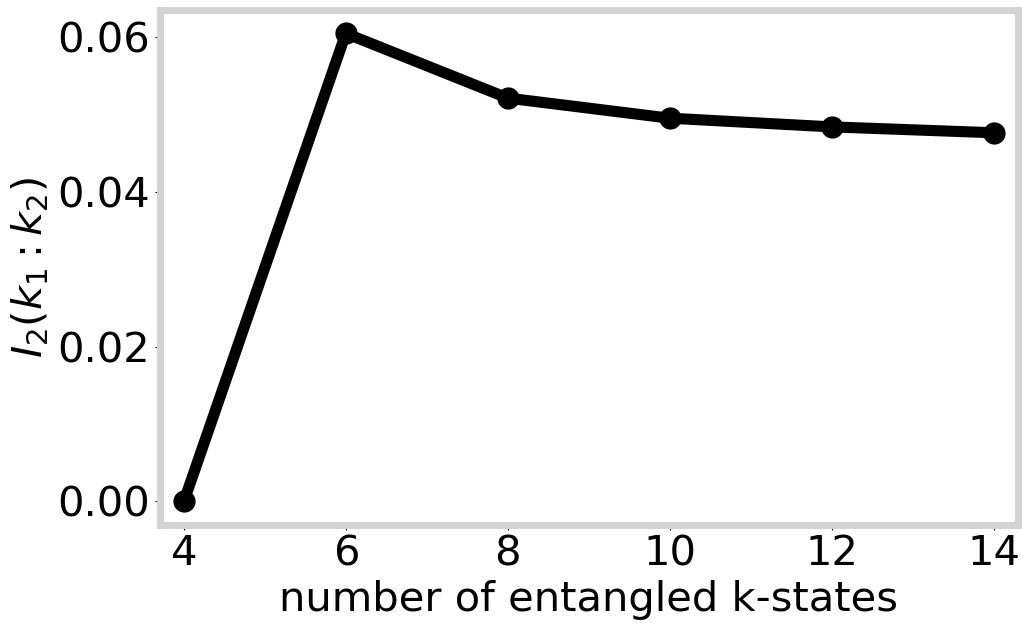

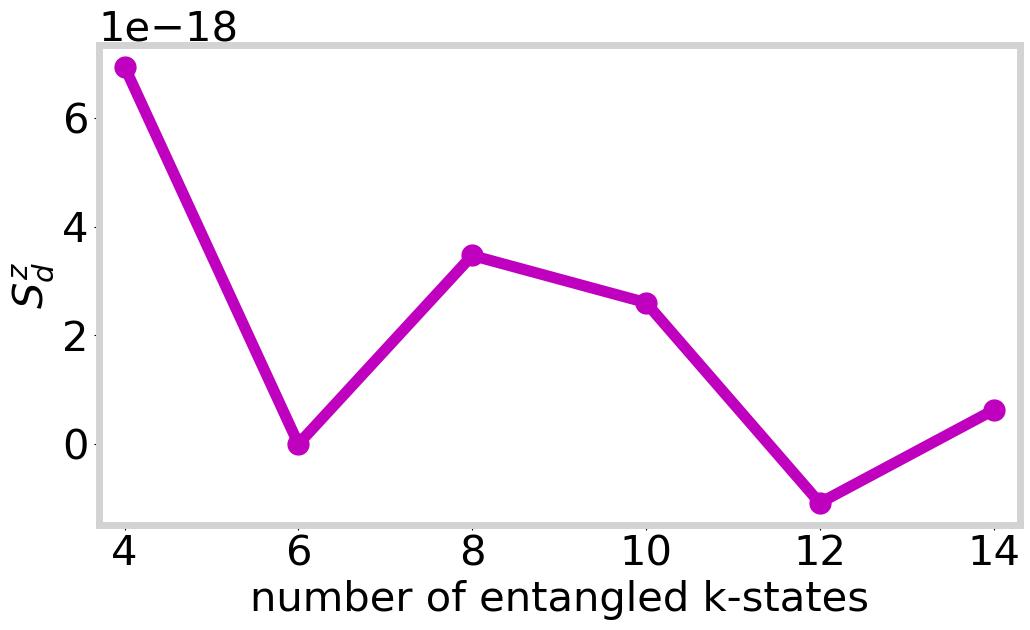

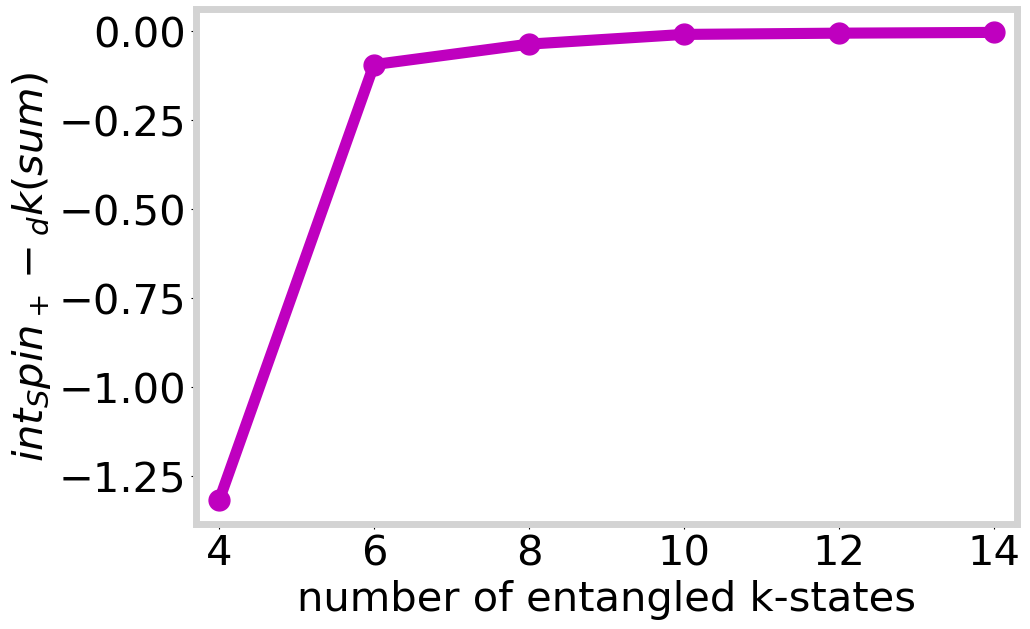

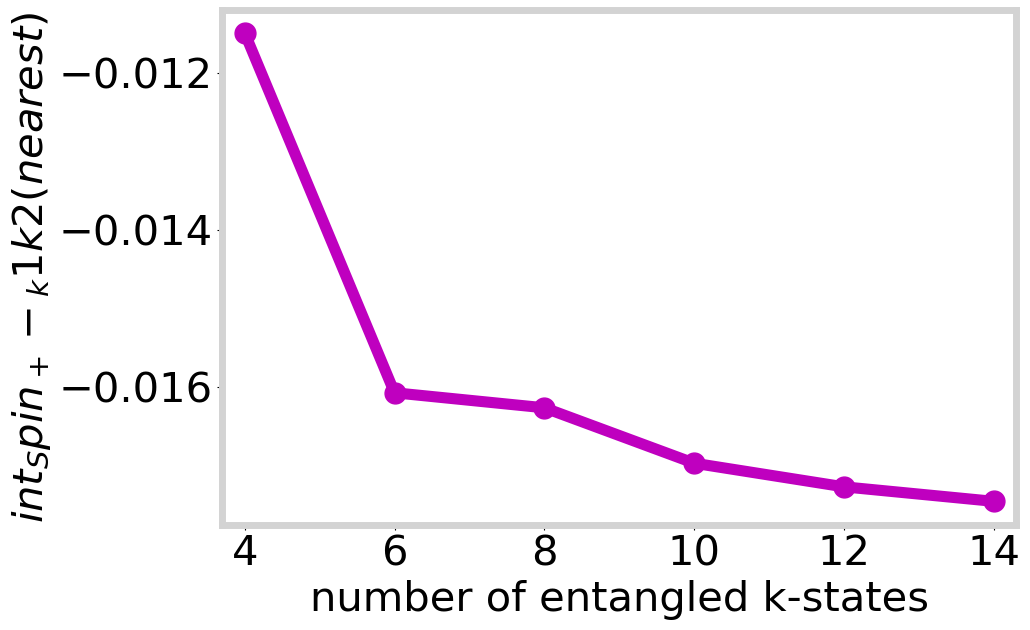

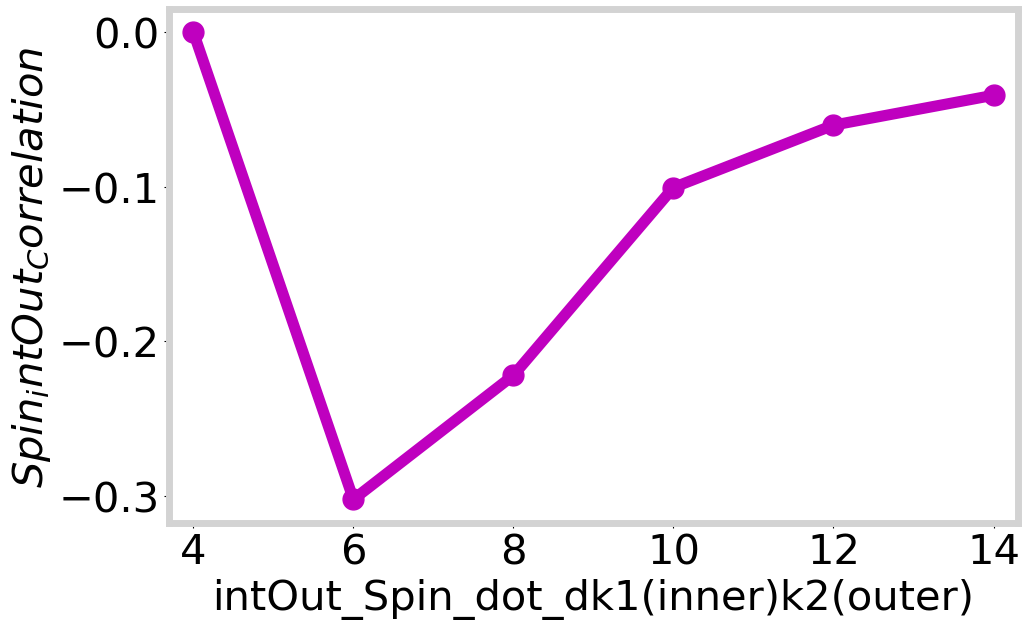

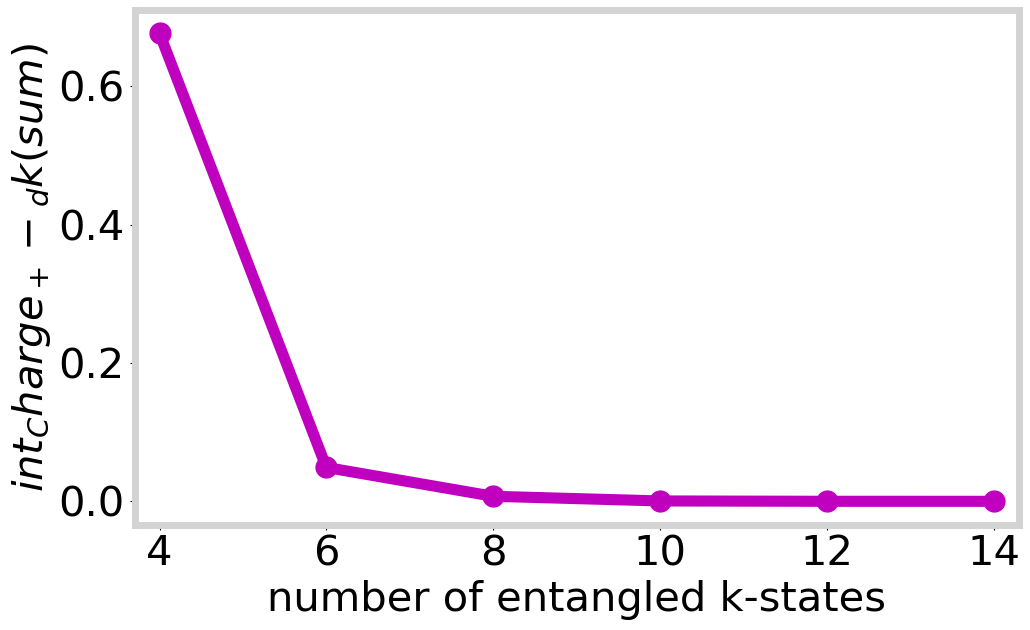

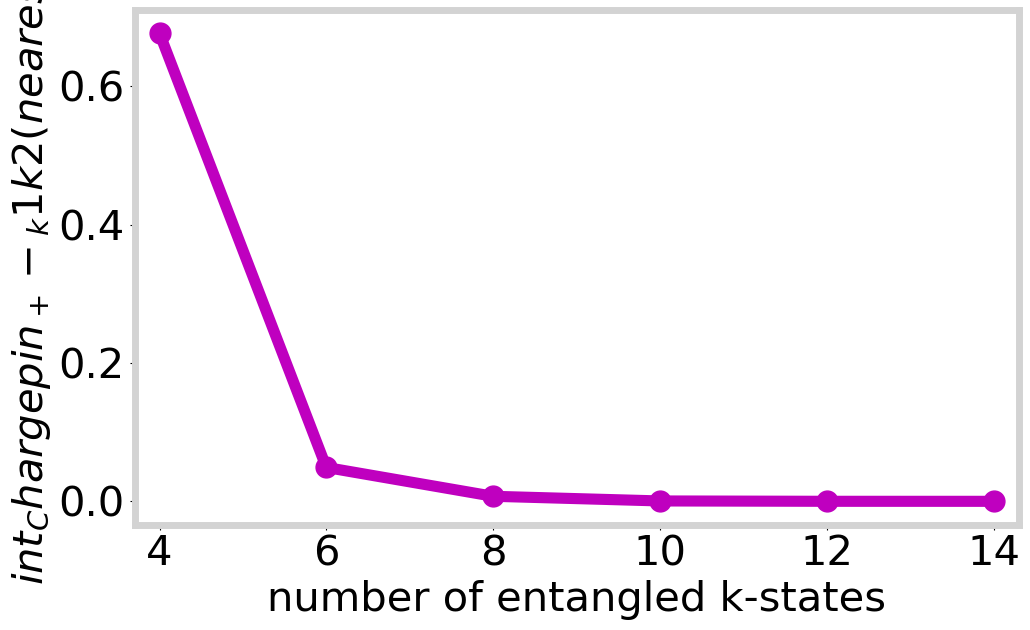

In [4]:
D0 = 1

V0 = D0/10

J0 = D0/10

Ub = -0.1 * J0

U0 = - 150 * Ub

num_entangled, num_IOMs, computation_results, comp_results, cm_result, cmp_result, Sdz, Spin_internal_Correlation, Spin_internal_Correlation_K, Spin_intOut_Correlation, Charge_internal_Correlation, Charge_internal_Correlation_K = eSIAM_MERG(D0, U0, V0, J0, Ub, 4, 5)

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), computation_results["VNE"], marker='o', c = 'g')
plt.ylabel(r"$S_{EE}(d)$")
plt.xlabel("number of entangled k-states")
plt.savefig("metal_r0.1_SEE_d.pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), comp_results["VNE"], marker='o', c = 'y')
plt.ylabel(r"$S_{EE}(K1)$")
plt.xlabel("number of entangled k-states")
plt.savefig("metal_r0.1_SEE_k1.pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), computation_results["I2"], marker='o',c = 'b')
plt.ylabel(r"$I_2(d:k_1)$")
plt.xlabel("number of entangled k-states")
plt.savefig("metal_r0.1_I2_dk1.pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), cm_result, marker='o',c = 'c')
plt.ylabel(r"$I_2(d:k_2)$")
plt.xlabel("number of entangled k-states")
plt.savefig("metal_r0.1_I2_dk2.pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), cmp_result, marker='o',c = 'k')
plt.ylabel(r"$I_2(k_1:k_2)$")
plt.xlabel("number of entangled k-states")
plt.savefig("metal_r0.1_I2_k1k2.pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), Sdz, marker='o',c = 'm')
plt.ylabel(r"$S_d^z$")
plt.xlabel("number of entangled k-states")
plt.savefig("metal_r0.1_Sdz.pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), Spin_internal_Correlation, marker='o',c = 'm')
plt.ylabel(r"$int_Spin_+-_dk(sum)$")
plt.xlabel("number of entangled k-states")
plt.savefig("metal_r0.1_int_Spin_+-_dk(sum).pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), Spin_internal_Correlation_K, marker='o',c = 'm')
plt.ylabel(r"$int_Spin_+-_k1k2(nearest)$")
plt.xlabel("number of entangled k-states")
plt.savefig("metal_r0.1_int_Spin_+-_k1k2(nearest).pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), Spin_intOut_Correlation, marker='o',c = 'm')
plt.ylabel(r"$Spin_intOut_Correlation$")
plt.xlabel("intOut_Spin_dot_dk1(inner)k2(outer)")
plt.savefig("metal_r0.1_intOut_Spin_dot_dk1(inner)k2(outer).pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), Charge_internal_Correlation, marker='o',c = 'm')
plt.ylabel(r"$int_Charge_+-_dk(sum)$")
plt.xlabel("number of entangled k-states")
plt.savefig("metal_r0.1_int_Charge_+-_dk(sum).pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), Charge_internal_Correlation, marker='o',c = 'm')
plt.ylabel(r"$int_Chargepin_+-_k1k2(nearest)$")
plt.xlabel("number of entangled k-states")
plt.savefig("metal_r0.1_int_Charge_+-_k1k2(nearest).pdf", bbox_inches='tight')
plt.show()


0.9650630640125065 0.991618154697261 1.0075999220220935
(-0.0643277301868143, -0.02180525321826289, 0.06516352503932069, 0.026651329378274198, -0.06606963656541626)


Obtaining operators for n .:   0%|          | 0/8 [00:00<?, ?it/s]

Obtaining operators for +- .:   0%|          | 0/4 [00:00<?, ?it/s]

Obtaining operators for +- .:   0%|          | 0/4 [00:00<?, ?it/s]

Obtaining operators for +- .:   0%|          | 0/4 [00:00<?, ?it/s]

Obtaining operators for +- .:   0%|          | 0/4 [00:00<?, ?it/s]

Obtaining operators for n .:   0%|          | 0/2 [00:00<?, ?it/s]

Obtaining operators for nn .:   0%|          | 0/1 [00:00<?, ?it/s]

Obtaining operators for n+- .:   0%|          | 0/64 [00:00<?, ?it/s]

Obtaining operators for +-+- .:   0%|          | 0/16 [00:00<?, ?it/s]

Obtaining operators for +- .:   0%|          | 0/16 [00:00<?, ?it/s]

Obtaining operators for +- .:   0%|          | 0/16 [00:00<?, ?it/s]

Obtaining operators for +-+- .:   0%|          | 0/256 [00:00<?, ?it/s]

Expressing state in terms of basis.:   0%|          | 0/1024 [00:00<?, ?it/s]

[-3.49284937 -3.49284937]
G-state energy: [-3.49284937]
{'0100000001': -3.752413555736309e-20, '0100000010': -2.4290017694463116e-16, '0100000011': 0.2545180780672078, '0100000100': 2.508800756134299e-16, '0100000101': -3.122502256758253e-17, '0100000110': -0.2529803722888485, '0100000111': -1.0824674490095276e-14, '0100001000': 1.4062102177136993e-16, '0100001001': 0.25298037228884945, '0100001010': 1.5881867761018131e-22, '0100001011': 2.8537731133079455e-22, '0100001100': 0.2514641706471407, '0100001101': 1.0522804388515298e-14, '0100001110': -2.7672757141190375e-22, '0100001111': -7.494178599599612e-28, '0100010000': -1.0145096996821199e-16, '0100010001': 1.3147125418476463e-18, '0100010010': -0.2514611708959173, '0100010011': -7.232574653250586e-15, '0100010100': -1.3065131925259533e-18, '0100010101': 7.52316384526264e-36, '0100010110': -3.2618974330341165e-15, '0100010111': -1.212228549285484e-38, '0100011000': -0.24996604626375807, '0100011001': -7.198169159690603e-15, '01000110

Computing VNE:   0%|          | 0/6 [00:00<?, ?it/s]

Computing I2:   0%|          | 0/6 [00:00<?, ?it/s]

N {'VNE': [-0.0, 0.09570309766829267, 0.10840235790737321, 0.1929312109687852, 0.2122964318389165, 0.2943224298759813], 'I2': [-4.440892098500626e-16, 3.533325603211068e-07, 2.477493301622502e-07, 5.006993120115766e-07, 4.1738241041144875e-07, 6.323488170867364e-07]}


Computing VNE:   0%|          | 0/6 [00:00<?, ?it/s]

T {'VNE': [1.1148131943194035, 1.114813329413015, 1.1148134710653719, 1.1148136294098885, 1.1148137966716254, 1.1148139578867142]}


Computing I2:   0%|          | 0/5 [00:00<?, ?it/s]

M [0, 0.09570084178479538, 0.09336018866971633, 0.07957234216549175, 0.07836994545983528, 0.07206096672158846]


Computing I2:   0%|          | 0/5 [00:00<?, ?it/s]

R [0, 4.081038156300565e-07, 4.0565054160168756e-07, 3.8937727153687263e-07, 3.8443717365055363e-07, 3.6576792572518e-07]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/2235 [00:00<?, ?it/s]

  0%|          | 0/5189 [00:00<?, ?it/s]

  0%|          | 0/16191 [00:00<?, ?it/s]

[-0.49999999999999994, -0.4915427933709077, -0.48948645540848806, -0.47857530321987984, -0.4743686332099036, -0.46102502705939197]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/2235 [00:00<?, ?it/s]

  0%|          | 0/5189 [00:00<?, ?it/s]

  0%|          | 0/16191 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/2235 [00:00<?, ?it/s]

  0%|          | 0/5189 [00:00<?, ?it/s]

  0%|          | 0/16191 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/2235 [00:00<?, ?it/s]

  0%|          | 0/5189 [00:00<?, ?it/s]

  0%|          | 0/16191 [00:00<?, ?it/s]

[0, -4.33971948174166e-06, -4.437882442439585e-06, -4.523324752407243e-06, -4.587035467529901e-06, -4.701047464613516e-06]


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/2235 [00:00<?, ?it/s]

  0%|          | 0/5189 [00:00<?, ?it/s]

  0%|          | 0/16191 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/2235 [00:00<?, ?it/s]

  0%|          | 0/5189 [00:00<?, ?it/s]

  0%|          | 0/16191 [00:00<?, ?it/s]

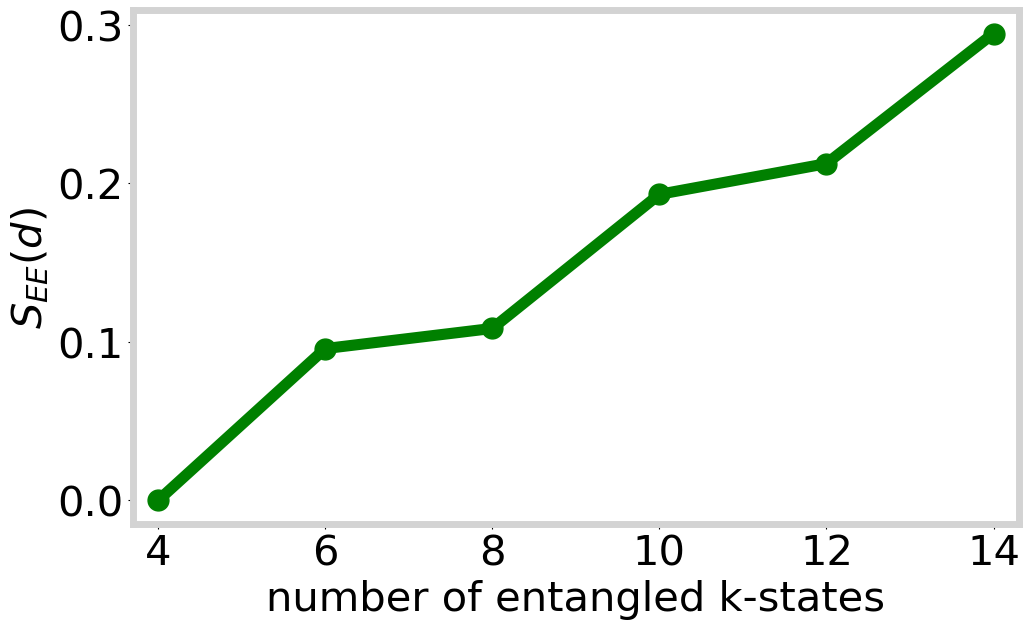

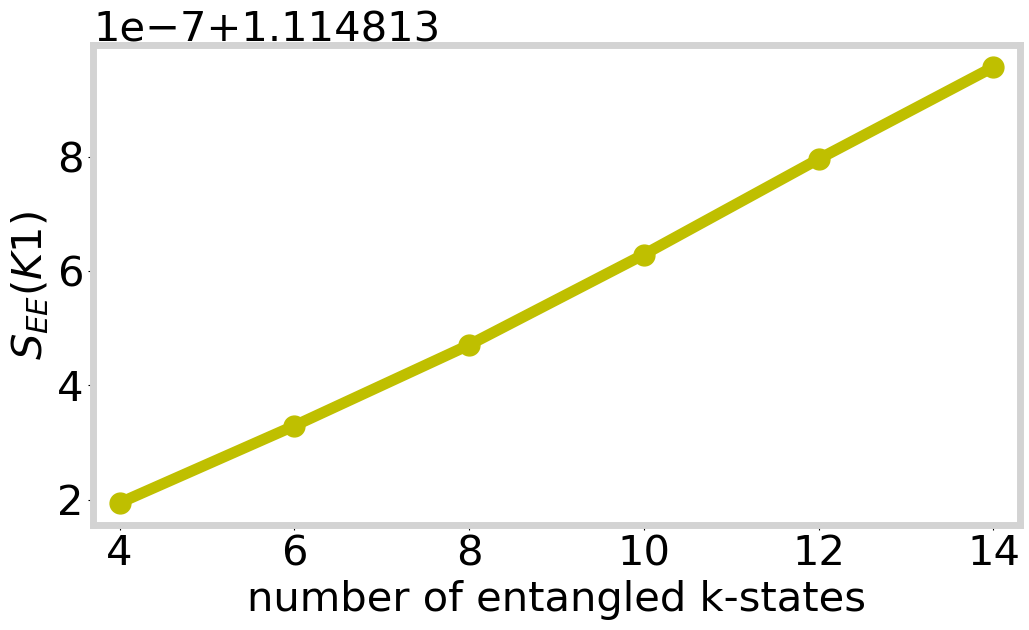

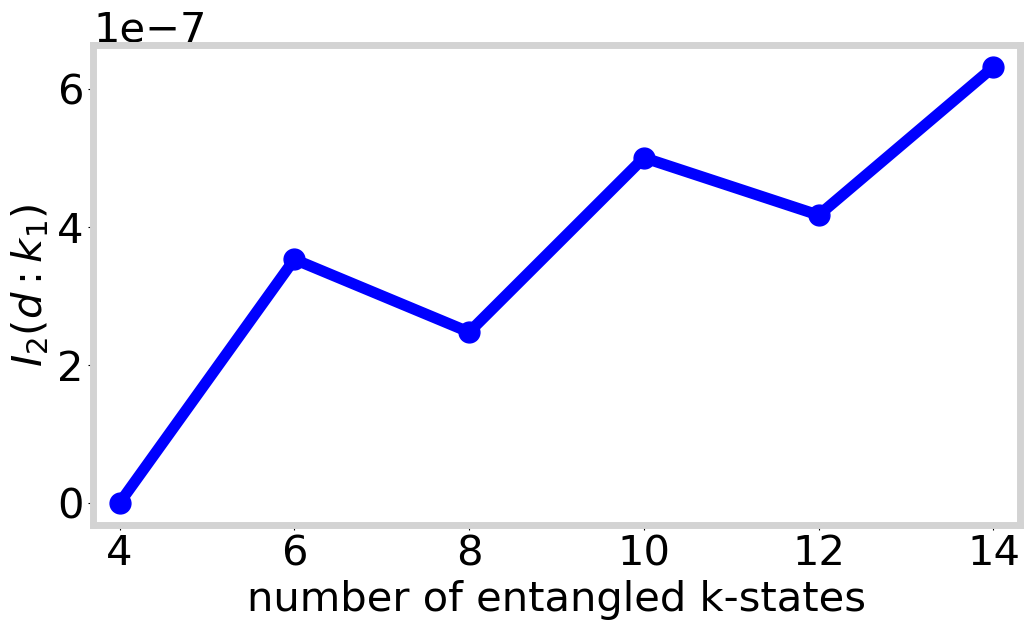

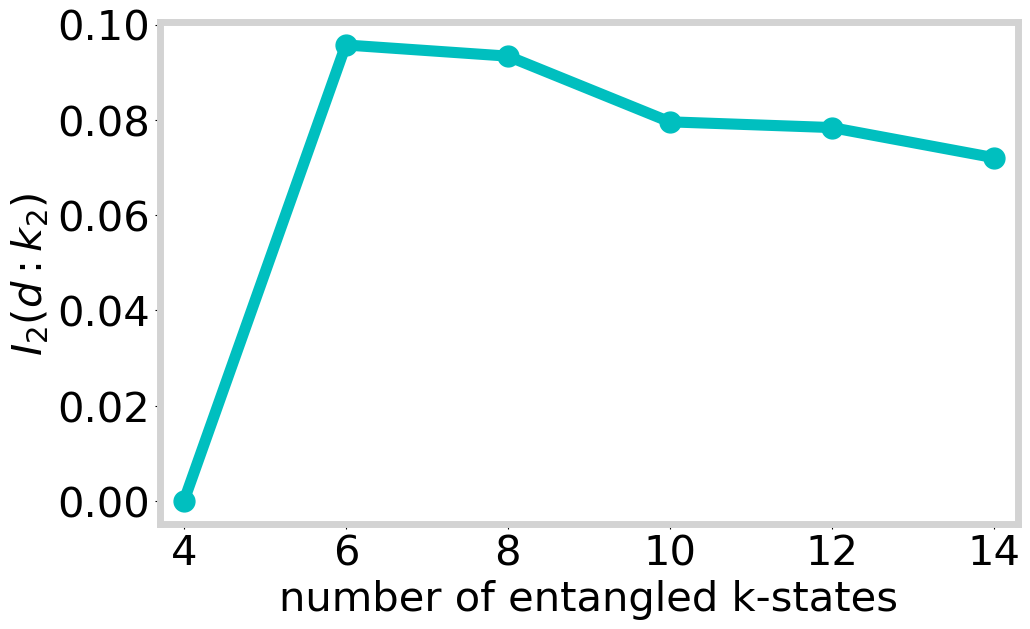

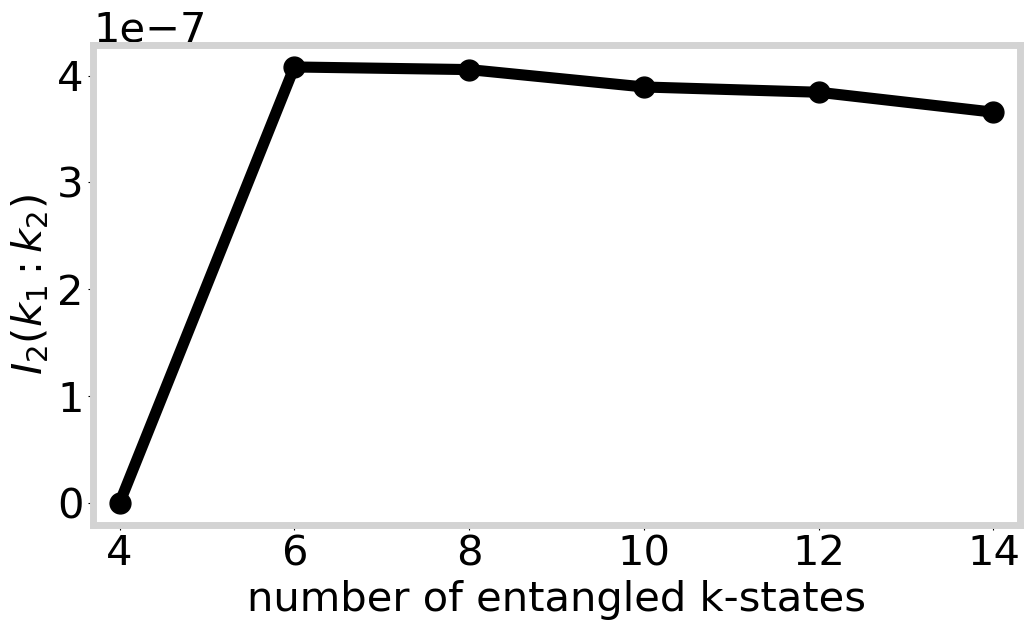

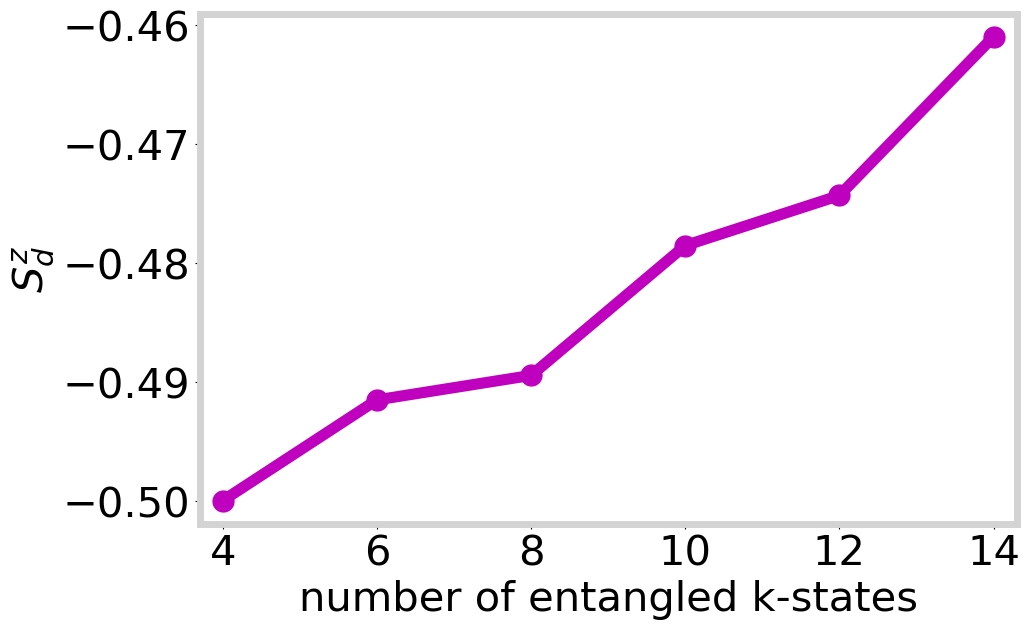

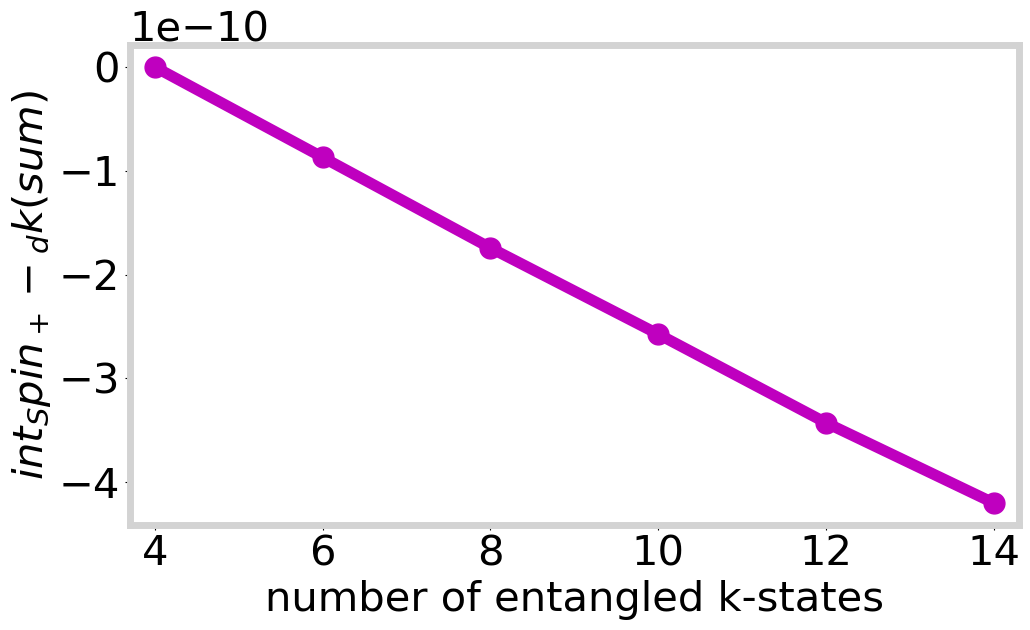

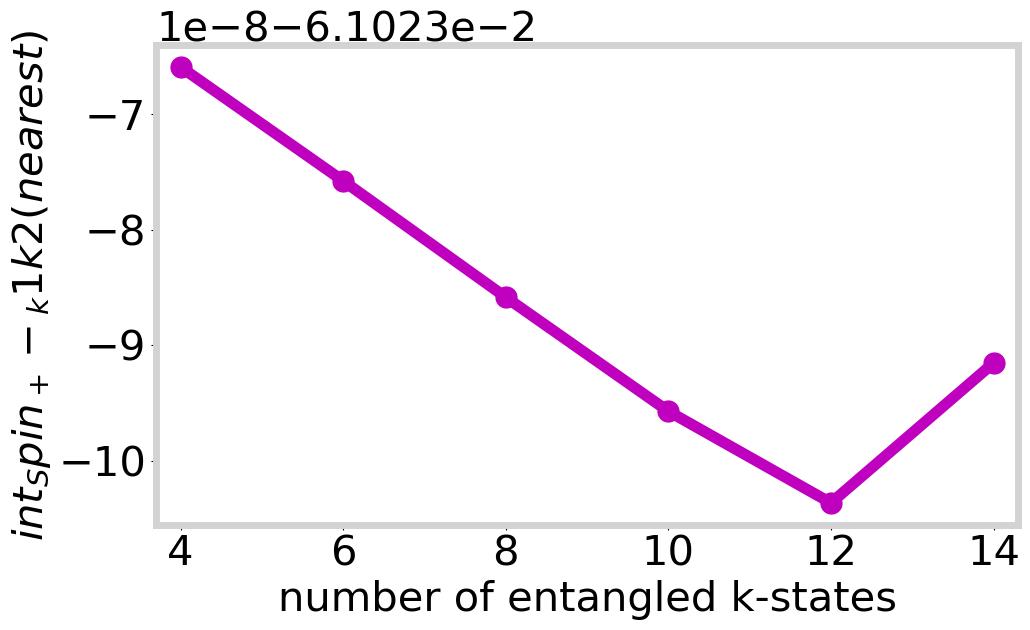

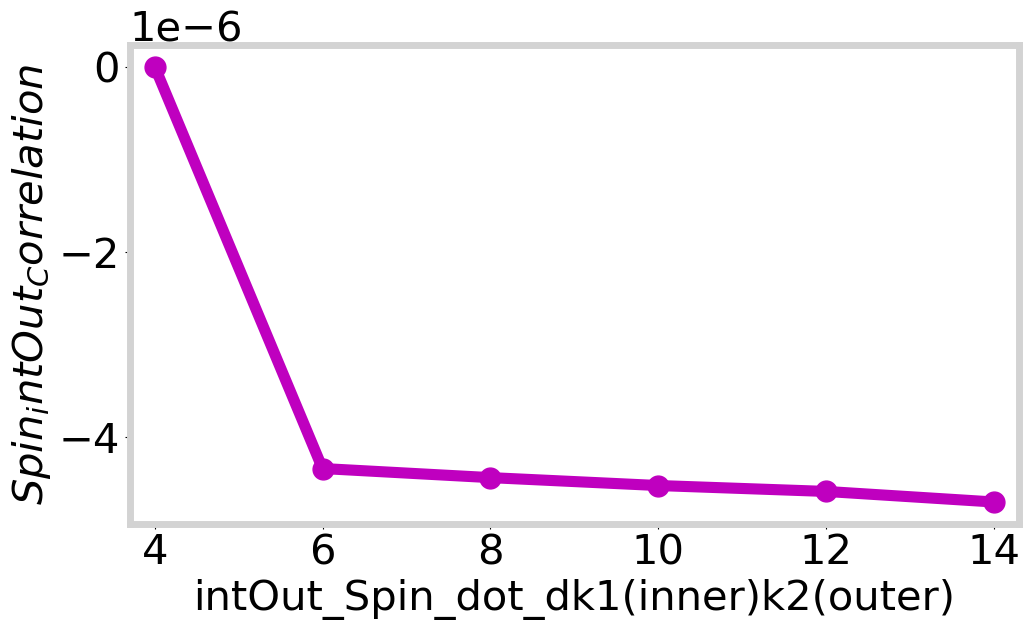

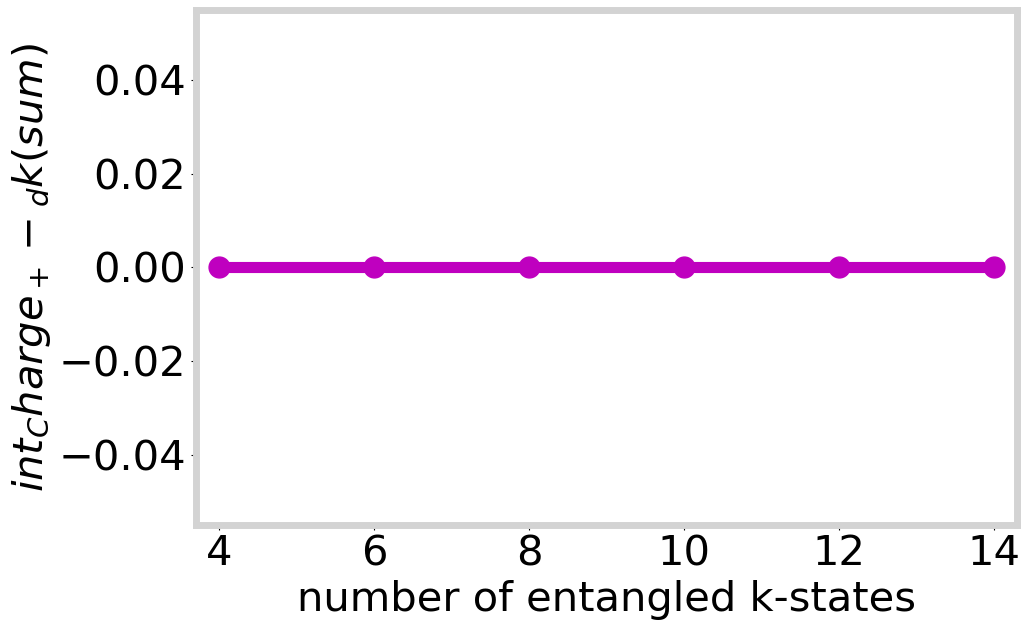

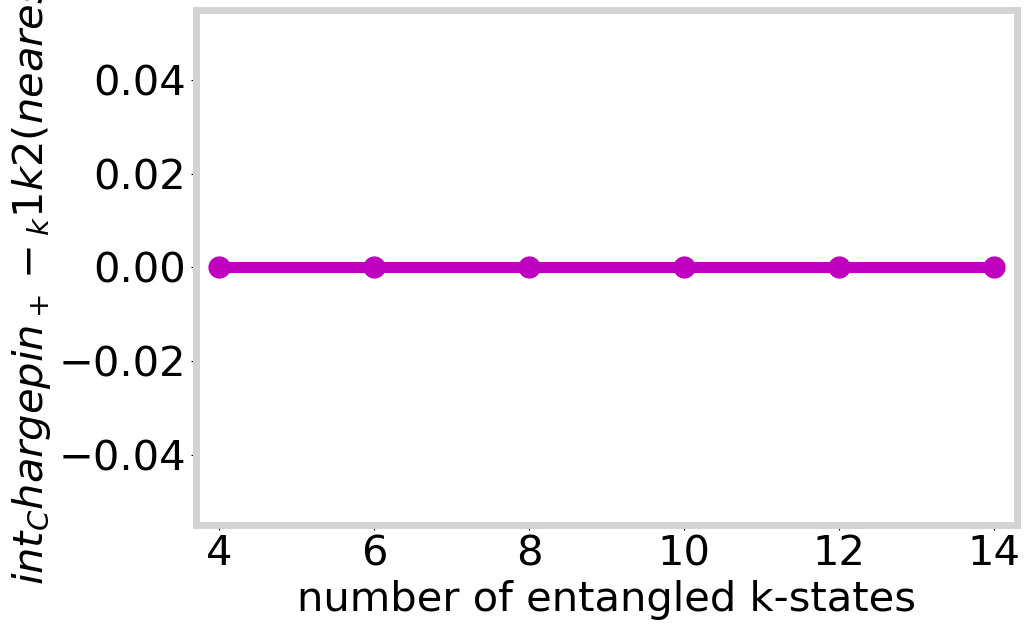

In [6]:
D0 = 1

V0 = D0/10

J0 = D0/10
Ub = -0.4 * J0

U0 = - 150 * Ub

num_entangled, num_IOMs, computation_results, comp_results, cm_result, cmp_result, Sdz, Spin_internal_Correlation, Spin_internal_Correlation_K, Spin_intOut_Correlation, Charge_internal_Correlation, Charge_internal_Correlation_K = eSIAM_MERG(D0, U0, V0, J0, Ub, 4, 5)

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), computation_results["VNE"], marker='o', c = 'g')
plt.ylabel(r"$S_{EE}(d)$")
plt.xlabel("number of entangled k-states")
plt.savefig("Insulator_r0.4_SEE_d.pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), comp_results["VNE"], marker='o', c = 'y')
plt.ylabel(r"$S_{EE}(K1)$")
plt.xlabel("number of entangled k-states")
plt.savefig("Insulator_r0.4_SEE_k1.pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), computation_results["I2"], marker='o',c = 'b')
plt.ylabel(r"$I_2(d:k_1)$")
plt.xlabel("number of entangled k-states")
plt.savefig("Insulator_r0.4_I2_dk1.pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), cm_result, marker='o',c = 'c')
plt.ylabel(r"$I_2(d:k_2)$")
plt.xlabel("number of entangled k-states")
plt.savefig("Insulator_r0.4_I2_dk2.pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), cmp_result, marker='o',c = 'k')
plt.ylabel(r"$I_2(k_1:k_2)$")
plt.xlabel("number of entangled k-states")
plt.savefig("Insulator_r0.4_I2_k1k2.pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), Sdz, marker='o',c = 'm')
plt.ylabel(r"$S_d^z$")
plt.xlabel("number of entangled k-states")
plt.savefig("Insulator_r0.4_Sdz.pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), Spin_internal_Correlation, marker='o',c = 'm')
plt.ylabel(r"$int_Spin_+-_dk(sum)$")
plt.xlabel("number of entangled k-states")
plt.savefig("Insulator_r0.4_int_Spin_+-_dk(sum).pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), Spin_internal_Correlation_K, marker='o',c = 'm')
plt.ylabel(r"$int_Spin_+-_k1k2(nearest)$")
plt.xlabel("number of entangled k-states")
plt.savefig("Insulator_r0.4_int_Spin_+-_k1k2(nearest).pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), Spin_intOut_Correlation, marker='o',c = 'm')
plt.ylabel(r"$Spin_intOut_Correlation$")
plt.xlabel("intOut_Spin_dot_dk1(inner)k2(outer)")
plt.savefig("Insulator_r0.4_intOut_Spin_dot_dk1(inner)k2(outer).pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), Charge_internal_Correlation, marker='o',c = 'm')
plt.ylabel(r"$int_Charge_+-_dk(sum)$")
plt.xlabel("number of entangled k-states")
plt.savefig("Insulator_r0.4_int_Charge_+-_dk(sum).pdf", bbox_inches='tight')
plt.show()

plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), Charge_internal_Correlation, marker='o',c = 'm')
plt.ylabel(r"$int_Chargepin_+-_k1k2(nearest)$")
plt.xlabel("number of entangled k-states")
plt.savefig("Insulator_r0.4_int_Charge_+-_k1k2(nearest).pdf", bbox_inches='tight')
plt.show()


In [ ]:
Insulator_r0.4